## Read in Data

In [115]:
import pandas as pd
import numpy as np
import math
import copy
import itertools
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(18, 16), dpi=180)

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

pd.set_option('display.max_columns', None)

<Figure size 3240x2880 with 0 Axes>

In [2]:
link = ('https://raw.githubusercontent.com/'
        'propublica/compas-analysis/master/compas-scores-two-years.csv')
feature = ['age', 'c_charge_degree', 'race', 'v_score_text', 'sex', 'priors_count', 
           'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid','c_jail_in', 'c_jail_out']
raw = pd.read_csv(link)[feature]
raw.head()

,age,c_charge_degree,race,v_score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
0,69,F,Other,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,34,F,African-American,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
3,23,F,African-American,Medium,Male,1,NaN,8,0,0,NaN,NaN
4,43,F,Other,Low,Male,2,NaN,1,0,0,NaN,NaN


## Data Cleaning and Transformation

· **Race**: Caucasian (2087) and African-American (3247)

In [3]:
#basic cleaning according to the data page

df = raw[(raw.race == 'Caucasian') | (raw.race == 'African-American')]
df = df[(df.days_b_screening_arrest < 30) & (df.days_b_screening_arrest >= -30)]
df.drop(columns=['days_b_screening_arrest'], inplace = True)
df = df[df.is_recid != -1]
df = df[df.c_charge_degree != 'O']
df['length_of_stay'] = (pd.to_datetime(df["c_jail_out"]) - pd.to_datetime(df['c_jail_in'])).dt.days
df.drop(columns=['c_jail_in', 'c_jail_out'], inplace=True)

df.head()

,age,c_charge_degree,race,v_score_text,sex,priors_count,decile_score,is_recid,two_year_recid,length_of_stay
1,34,F,African-American,Low,Male,0,3,1,1,10
2,24,F,African-American,Low,Male,4,4,1,1,1
6,41,F,Caucasian,Low,Male,14,6,1,1,6
8,39,M,Caucasian,Low,Female,0,1,0,0,2
10,27,F,Caucasian,Low,Male,0,4,0,0,1


· **Age**: age < 25, 25 < age < 45, age > 45  
· **Charge Degree**: Misdemeanor or Felony  
· **Gender**: Male or Female  
· **Prior Counts**: 0, 1-3, larger than 3  
· **Length of Stay**: <= 1 week, <= 3 months or > 3 months  

In [4]:
## Encoding

catgorical = df.columns[df.dtypes == 'object']
for fea in catgorical:
    new_fea = LabelEncoder().fit_transform(df[fea])
    df[fea] = new_fea
    
df['age_cat'] = pd.cut(df['age'], bins = [0, 25, 45, 100], labels = [0, 1, 2])
df['priors_count_cat'] = pd.cut(df['priors_count'], bins = [-5, 0, 3, np.inf], labels = [0, 1, 2])
df['length_cat'] = pd.cut(df['length_of_stay'], bins = [0, 7, 90, np.inf], labels = [0, 1, 2])
df_clean = df[['race', 'age_cat', 'c_charge_degree', 'sex', 'priors_count_cat', 'length_cat', 'two_year_recid']]
df_clean = df_clean.dropna()
df_clean.head()

# to reproduce the origin experiment in paper A7, we select the age, charge_degree, sex, priors_count
# and length_of_stay as our main features

,race,age_cat,c_charge_degree,sex,priors_count_cat,length_cat,two_year_recid
1,0,1,0,1,0,1,1
2,0,0,0,1,2,0,1
6,1,1,0,1,2,0,1
8,1,1,1,0,0,0,0
10,1,1,0,1,0,0,0


Split the data as training : validation : testing = 5:1:1

In [5]:
# train_test_split

y = df_clean.two_year_recid
X = df_clean.drop(columns=['two_year_recid'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, stratify=y, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/6, 
                                                   stratify=y_train, random_state = 123)

In [6]:
# Race as protected attributes(senesitive features)

X_train_sen = np.array(X_train['race'])
X_train = np.array(X_train.drop(columns = ['race']))
X_val_sen = np.array(X_val['race'])
X_val = np.array(X_val.drop(columns = ['race']))

# For calculating calibration, split the test dataset to different race
X_test_AA = np.array(X_test[X_test.race == 0])
X_test_CA = np.array(X_test[X_test.race == 1])

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test_AA = np.array(y_test[X_test.race == 0])
y_test_CA = np.array(y_test[X_test.race == 1])

X_test = np.array(X_test)
y_test = np.array(y_test)

## A7:Information Theoretic Measures for Fairness-aware Feature Selection 

In [7]:
# shapley value calculation functions

def uniq_vals_in_arr(arr):

    uniq_vals = []
    for id_col in range(arr.shape[1]):
        uniq_vals.append(np.unique(arr[:, id_col]).tolist())
    return uniq_vals


def powerset(seq):

    if len(seq) <= 1:
        yield seq
        yield []
    else:
        for item in powerset(seq[1:]):
            yield [seq[0]]+item
            yield item


def info_coef(left, right):
    # Both arrays NEED same number of rows
    assert left.shape[0] == right.shape[0]
    num_rows = left.shape[0]
    num_left_cols = left.shape[1]
        
    concat_mat = np.concatenate((left, right), axis=1)
    concat_uniq_vals = uniq_vals_in_arr(concat_mat)
    concat_combos = list(itertools.product(*concat_uniq_vals))
    p_sum = 0
    for vec in concat_combos:
        p_r1_r2 = len(np.where((concat_mat == vec).all(axis=1))[0]) / num_rows
        p_r1 = len(np.where((left == vec[:num_left_cols]).all(axis=1))[0]) / num_rows
        p_r2 = len(np.where((right == vec[num_left_cols:]).all(axis=1))[0]) / num_rows
        
        if p_r1_r2 == 0 or p_r1 == 0 or p_r2 == 0:
            p_iter = 0
        else:
            p_iter = p_r1_r2 * np.log(p_r1_r2 / p_r1) / p_r1
        p_sum += np.abs(p_iter)
    return p_sum


def conditional_info_coef(left, right, conditional): 
    assert (left.shape[0] == right.shape[0]) and (left.shape[0] == conditional.shape[0])
    num_rows = left.shape[0]
    num_left_cols = left.shape[1]
    num_right_cols = right.shape[1]

    right_concat_mat = np.concatenate((right, conditional), axis=1)    
    concat_mat = np.concatenate((left, right_concat_mat), axis=1)
    concat_uniq_vals = uniq_vals_in_arr(concat_mat)
    concat_combos = list(itertools.product(*concat_uniq_vals))
    p_sum = 0
    for vec in concat_combos:
        p_r1_r2 = len(np.where((concat_mat == vec).all(axis=1))[0]) / num_rows
        p_r1 = len(np.where((left == vec[:num_left_cols]).all(axis=1))[0]) / num_rows
        p_r2 = len(np.where((concat_mat[:, num_left_cols: -num_right_cols] == vec[num_left_cols: -num_right_cols]).all(axis=1))[0]) / num_rows
        
        try:
            p_r1_given_r3 = len(np.where((concat_mat[:, :num_left_cols] == vec[:num_left_cols]).all(axis=1) & (concat_mat[:, -num_right_cols:] == vec[-num_right_cols:]).all(axis=1))[0]) / len(np.where((concat_mat[:, -num_right_cols:] == vec[-num_right_cols:]).all(axis=1))[0])
        except ZeroDivisionError:
            p_r1_given_r3 = 0
        
        if p_r1_r2 == 0 or p_r1 == 0 or p_r2 == 0 or p_r1_given_r3 == 0:
            p_iter = 0
        else:
            p_iter = p_r1_r2 * np.log(p_r1_r2 / p_r2) / p_r1_given_r3
        p_sum += np.abs(p_iter)
    return p_sum


def acc_coef(y, x_s, x_s_c, sensitive):
    conditional = np.concatenate((x_s_c, sensitive), axis=1)
    return conditional_info_coef(y, x_s, conditional)


def disc_coef(y, x_s, sensitive):
    x_s_a = np.concatenate((x_s, sensitive), axis=1)
    return info_coef(y, x_s_a) * info_coef(x_s, sensitive) * conditional_info_coef(x_s, sensitive, y)


def shapley_acc(y, x, sensitive, i):
    num_features = x.shape[1]
    lst_idx = list(range(num_features))
    lst_idx.pop(i)
    power_set = [x for x in powerset(lst_idx) if len(x) > 0]
    
    shapley = 0
    for set_idx in power_set:
        coef = math.factorial(len(set_idx)) * math.factorial(num_features - len(set_idx) - 1) / math.factorial(num_features)
        
        # Calculate v(T U {i})
        idx_xs_incl = copy.copy(set_idx)
        idx_xs_incl.append(i)
        idx_xsc_incl = list(set(list(range(num_features))).difference(set(idx_xs_incl)))
        acc_incl = acc_coef(y.reshape(-1, 1), x[:, idx_xs_incl], x[:, idx_xsc_incl], sensitive.reshape(-1, 1))
        
        # Calculate v(T)
        idx_xsc_excl = list(range(num_features))
        idx_xsc_excl.pop(i)
        idx_xsc_excl = list(set(idx_xsc_excl).difference(set(set_idx)))
        acc_excl = acc_coef(y.reshape(-1, 1), x[:, set_idx], x[:, idx_xsc_excl], sensitive.reshape(-1, 1))
        
        marginal = acc_incl - acc_excl
        shapley = shapley + coef * marginal
    return shapley


def shapley_disc(y, x, sensitive, i):
  
    num_features = x.shape[1]
    lst_idx = list(range(num_features))
    lst_idx.pop(i)
    power_set = [x for x in powerset(lst_idx) if len(x) > 0]
    
    shapley = 0
    for set_idx in power_set:
        coef = math.factorial(len(set_idx)) * math.factorial(num_features - len(set_idx) - 1) / math.factorial(num_features)
        
        # Calculate v_D(T U {i})
        idx_xs_incl = copy.copy(set_idx)
        idx_xs_incl.append(i)
        disc_incl = disc_coef(y.reshape(-1, 1), x[:, idx_xs_incl], sensitive.reshape(-1, 1))
        
        # Calculate v_D(T)
        disc_excl = disc_coef(y.reshape(-1, 1), x[:, set_idx], sensitive.reshape(-1, 1))
        
        marginal = disc_incl - disc_excl
        shapley = shapley + coef * marginal
    return shapley


def shapley(train_set):
    
    shap_acc = []
    shap_disc = []
    for i in range(5):
        acc_i = shapley_acc(train_set[0],train_set[1], train_set[2],i)
        disc_i = shapley_disc(train_set[0],train_set[1], train_set[2], i)

        shap_acc.append(acc_i)
        shap_disc.append(disc_i)
    return [shap_acc, shap_disc]


In [33]:
## Feature Selection Result

train_set = [y_train, X_train, X_train_sen]
shaply = shapley(train_set)
feature_names = ['Age', 'Charge Degree', 'Gender', 'Prior Counts', 'Length of Stay']
pd.DataFrame(list(zip(feature_names, shaply[0], shaply[1])), columns = ['Features', 'Accuracy', 'Discrimination'])

,Features,Accuracy,Discrimination
0,Age,1.210114,46772.615106
1,Charge Degree,1.087360,37525.470930
2,Gender,0.969253,37630.375782
3,Prior Counts,1.248108,47161.541173
4,Length of Stay,1.190087,46187.281878


**Conclusion**: We Applied the measure of accuracy and discrimination to the dataset. The result shows that **Age** and **Prior Counts** show strongest proxies for discrimination. This is in line with the conclusion of paper A7. However, both features show the strongest proxies for model accuracies as well. Thus, a naive decision to drop **Age** or **Prior Counts** would highly reduce the model accuracy.   

To make a wise decision for fairness-aware feature selection, we can compute the fairness-utility score which is based on the shapley value and a positive hyperparamter $\alpha$. The choice of $\alpha$ helps trade off between accuracy and discrimination.


## Model Selection and Evaluation

### Hyperparameter Tuning

In [34]:

def fairness_score(shaply, alpha):
    shap_score = []
    for i in range(5):
        score = shaply[0][i] - alpha * shaply[1][i]
        
        shap_score.append(score)
    return [shaply[0], shaply[1], shap_score]


**(1) $\alpha = 0.000001$**

In [76]:
## Feature Selection Result

#train_set = [y_train, X_train, X_train_sen]
score_1 = fairness_score(shaply, 0.000001)
feature_names = ['Age', 'Charge Degree', 'Gender', 'Prior Counts', 'Length of Stay']
pd.DataFrame(list(zip(feature_names, score_1[0], score_1[1], score_1[2])), columns = ['Features', 'Accuracy', 'Discrimination', 'fairness-utility score'])

,Features,Accuracy,Discrimination,fairness-utility score
0,Age,1.210114,46772.615106,1.163341
1,Charge Degree,1.087360,37525.470930,1.049834
2,Gender,0.969253,37630.375782,0.931623
3,Prior Counts,1.248108,47161.541173,1.200947
4,Length of Stay,1.190087,46187.281878,1.143899


**(2) $\alpha = 0.00001$**

In [77]:
## Feature Selection Result

#train_set = [y_train, X_train, X_train_sen]
score_2 = fairness_score(shaply, 0.00001)
feature_names = ['Age', 'Charge Degree', 'Gender', 'Prior Counts', 'Length of Stay']
pd.DataFrame(list(zip(feature_names, score_2[0], score_2[1], score_2[2])), columns = ['Features', 'Accuracy', 'Discrimination', 'fairness-utility score'])

,Features,Accuracy,Discrimination,fairness-utility score
0,Age,1.210114,46772.615106,0.742387
1,Charge Degree,1.087360,37525.470930,0.712105
2,Gender,0.969253,37630.375782,0.592949
3,Prior Counts,1.248108,47161.541173,0.776493
4,Length of Stay,1.190087,46187.281878,0.728214


**(3) $\alpha = 0.00003$**

In [78]:
## Feature Selection Result

#train_set = [y_train, X_train, X_train_sen]
score_3 = fairness_score(shaply, 0.00003)
feature_names = ['Age', 'Charge Degree', 'Gender', 'Prior Counts', 'Length of Stay']
pd.DataFrame(list(zip(feature_names, score_3[0], score_3[1], score_3[2])), columns = ['Features', 'Accuracy', 'Discrimination', 'fairness-utility score'])

,Features,Accuracy,Discrimination,fairness-utility score
0,Age,1.210114,46772.615106,-0.193065
1,Charge Degree,1.087360,37525.470930,-0.038404
2,Gender,0.969253,37630.375782,-0.159658
3,Prior Counts,1.248108,47161.541173,-0.166738
4,Length of Stay,1.190087,46187.281878,-0.195532


**(4) $\alpha = 0.00005$**

In [120]:
## Feature Selection Result

#train_set = [y_train, X_train, X_train_sen]
score_4 = fairness_score(shaply, 0.00005)
feature_names = ['Age', 'Charge Degree', 'Gender', 'Prior Counts', 'Length of Stay']
pd.DataFrame(list(zip(feature_names, score_4[0], score_4[1], score_4[2])), columns = ['Features', 'Accuracy', 'Discrimination', 'fairness-utility score'])

,Features,Accuracy,Discrimination,fairness-utility score
0,Age,1.210114,46772.615106,-1.128517
1,Charge Degree,1.087360,37525.470930,-0.788914
2,Gender,0.969253,37630.375782,-0.912266
3,Prior Counts,1.248108,47161.541173,-1.109969
4,Length of Stay,1.190087,46187.281878,-1.119278


**(5) $\alpha = 0.0001$**

In [125]:
## Feature Selection Result

#train_set = [y_train, X_train, X_train_sen]
score_5 = fairness_score(shaply, 0.0001)
feature_names = ['Age', 'Charge Degree', 'Gender', 'Prior Counts', 'Length of Stay']
pd.DataFrame(list(zip(feature_names, score_5[0], score_5[1], score_5[2])), columns = ['Features', 'Accuracy', 'Discrimination', 'fairness-utility score'])

,Features,Accuracy,Discrimination,fairness-utility score
0,Age,1.210114,46772.615106,-3.467148
1,Charge Degree,1.087360,37525.470930,-2.665187
2,Gender,0.969253,37630.375782,-2.793785
3,Prior Counts,1.248108,47161.541173,-3.468046
4,Length of Stay,1.190087,46187.281878,-3.428642


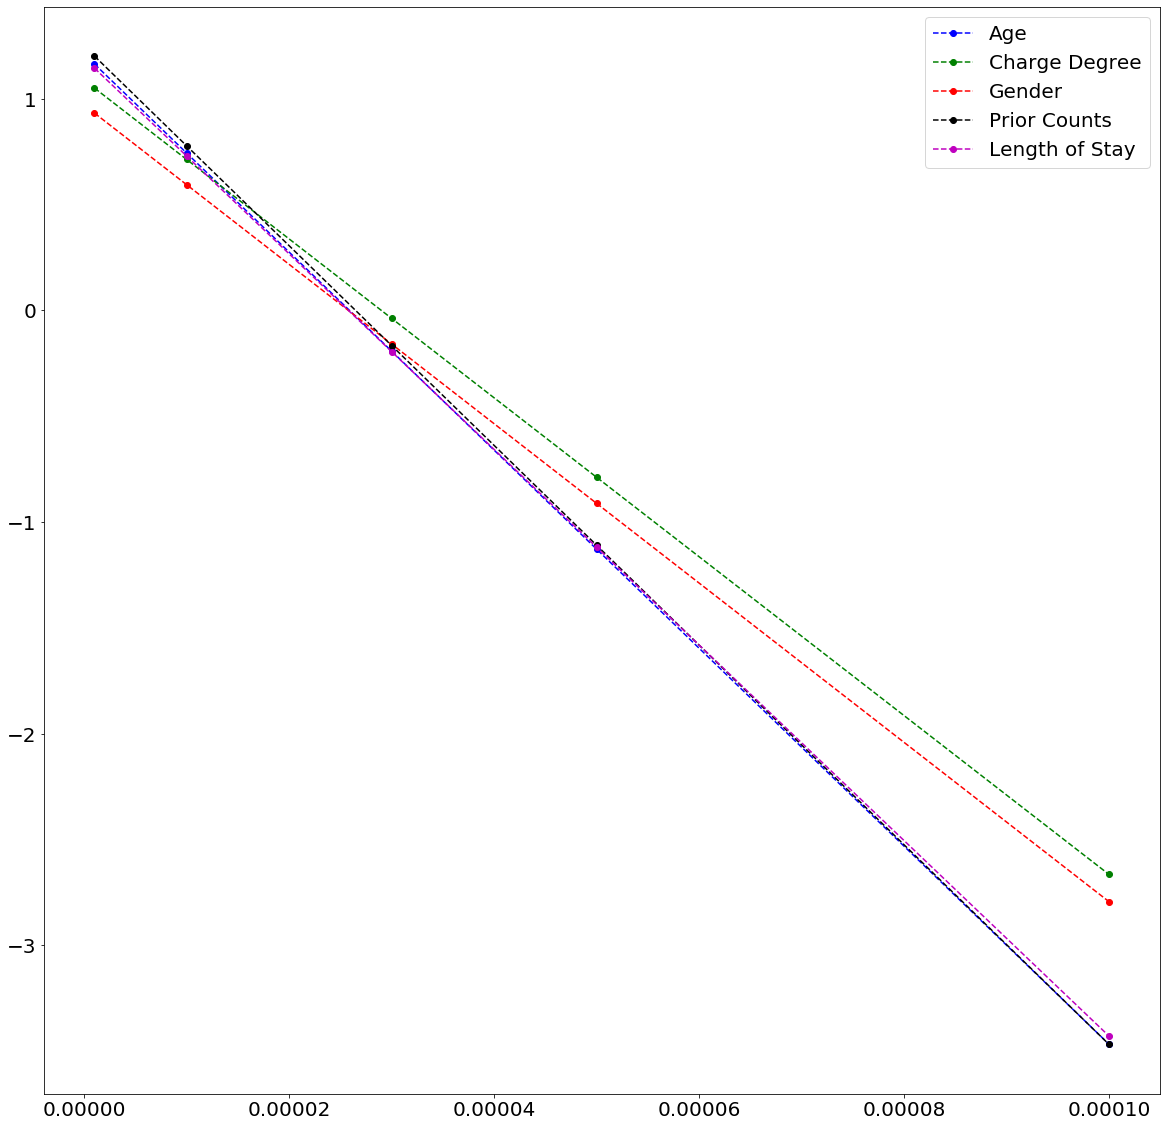

In [127]:
plt.figure(figsize=(20, 20))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rc('legend', fontsize=20)
#xpoints = np.array(['0.000001', '0.00001', '0.00003', '0.00005', '0.0001'])
xpoints = np.array([0.000001, 0.00001, 0.00003, 0.00005, 0.0001])
y_age = np.array([score_1[2][0], score_2[2][0], score_3[2][0], score_4[2][0], score_5[2][0]])
plt.plot(xpoints, y_age, '--bo', label = 'Age')
y_charge = np.array([score_1[2][1], score_2[2][1], score_3[2][1], score_4[2][1], score_5[2][1]])
plt.plot(xpoints, y_charge, '--go', label = 'Charge Degree')
y_gender = np.array([score_1[2][2], score_2[2][2], score_3[2][2], score_4[2][2], score_5[2][2]])
plt.plot(xpoints, y_gender, '--ro', label = 'Gender')
y_prior = np.array([score_1[2][3], score_2[2][3], score_3[2][3], score_4[2][3], score_5[2][3]])
plt.plot(xpoints, y_prior, '--ko', label = 'Prior Counts')
y_length = np.array([score_1[2][4], score_2[2][4], score_3[2][4], score_4[2][4], score_5[2][4]])
plt.plot(xpoints, y_length, '--mo', label = 'Length of Stay')
plt.legend()

We'd like to remove the feature with the lowest fairness-utility score from the overall five features. From the plot, we observe the lowest fairness-utility score:

1) When $\alpha = 0.000001$ and $\alpha = 0.00001$, **Gender**;

2) When $\alpha = 0.00003$, **Length of Stay**;

3) When $\alpha = 0.00005$, **Age**;

4) When $\alpha = 0.0001$, **Prior Counts**.
    
Basically, if we care about maintaining a very high accuracy, we can choose to remove **Gender**; If we want to minimize the discrimination effect, we can choose to remove **Prior Counts**. 

Next, we will build a set of classification models based on logistic regression. We will first regress on the whole five features, and then remove one feature from **Gender**, **Length of Stay**, **Age**, and **Prior Counts** respectively and compare their accuracy and calibration. 

### Building the model

#### (1) With all 5 features

In [9]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [10]:
y_test_predict_all = lr.predict(np.delete(X_test, 0, axis = 1))
print(f'AUC:{roc_auc_score(y_test, y_test_predict_all):.2f}')
print(f'Precision:{precision_score(y_test, y_test_predict_all):.2f}')
print(f'Recall:{recall_score(y_test, y_test_predict_all):.2f}')
print(f'Accuracy:{accuracy_score(y_test, y_test_predict_all):.5f}')

AUC:0.68
Precision:0.69
Recall:0.69
Accuracy:0.67967


In [11]:
y_test_predict_AA_all = lr.predict(np.delete(X_test_AA, 0, axis = 1))
y_test_predict_CA_all = lr.predict(np.delete(X_test_CA, 0, axis = 1))
accuracy_AA_all = accuracy_score(y_test_AA, y_test_predict_AA_all)
accuracy_CA_all = accuracy_score(y_test_CA, y_test_predict_CA_all)
print(f'Calibration:{abs(accuracy_AA_all-accuracy_CA_all):.5f}')

Calibration:0.07084


#### (2) Remove Gender

In [138]:
lr2 = LogisticRegression()
lr2.fit(np.delete(X_train, 2, axis = 1), y_train)

LogisticRegression()

In [141]:
y_test_predict2 = lr2.predict(np.delete(X_test, [0, 3], axis = 1))
print(f'AUC:{roc_auc_score(y_test, y_test_predict2):.2f}')
print(f'Precision:{precision_score(y_test, y_test_predict2):.2f}')
print(f'Recall:{recall_score(y_test, y_test_predict2):.2f}')
print(f'Accuracy:{accuracy_score(y_test, y_test_predict2):.5f}')

AUC:0.67
Precision:0.68
Recall:0.69
Accuracy:0.67351


In [143]:
y_test_predict_AA2 = lr2.predict(np.delete(X_test_AA, [0, 3], axis = 1))
y_test_predict_CA2 = lr2.predict(np.delete(X_test_CA, [0, 3], axis = 1))
accuracy_AA2 = accuracy_score(y_test_AA, y_test_predict_AA2)
accuracy_CA2 = accuracy_score(y_test_CA, y_test_predict_CA2)
print(f'Calibration:{abs(accuracy_AA2-accuracy_CA2):.5f}')

Calibration:0.04339


#### (3) Remove Length of Stay

In [144]:
lr3 = LogisticRegression()
lr3.fit(np.delete(X_train, 4, axis = 1), y_train)

LogisticRegression()

In [145]:
y_test_predict3 = lr3.predict(np.delete(X_test, [0, 5], axis = 1))
print(f'AUC:{roc_auc_score(y_test, y_test_predict3):.2f}')
print(f'Precision:{precision_score(y_test, y_test_predict3):.2f}')
print(f'Recall:{recall_score(y_test, y_test_predict3):.2f}')
print(f'Accuracy:{accuracy_score(y_test, y_test_predict3):.5f}')

AUC:0.65
Precision:0.66
Recall:0.69
Accuracy:0.65503


In [146]:
y_test_predict_AA3 = lr3.predict(np.delete(X_test_AA, [0, 5], axis = 1))
y_test_predict_CA3 = lr3.predict(np.delete(X_test_CA, [0, 5], axis = 1))
accuracy_AA3 = accuracy_score(y_test_AA, y_test_predict_AA3)
accuracy_CA3 = accuracy_score(y_test_CA, y_test_predict_CA3)
print(f'Calibration:{abs(accuracy_AA3-accuracy_CA3):.5f}')

Calibration:0.08590


#### (4) Remove Age

In [148]:
lr4 = LogisticRegression()
lr4.fit(np.delete(X_train, 0, axis = 1), y_train)

LogisticRegression()

In [149]:
y_test_predict4 = lr4.predict(np.delete(X_test, [0, 1], axis = 1))
print(f'AUC:{roc_auc_score(y_test, y_test_predict4):.2f}')
print(f'Precision:{precision_score(y_test, y_test_predict4):.2f}')
print(f'Recall:{recall_score(y_test, y_test_predict4):.2f}')
print(f'Accuracy:{accuracy_score(y_test, y_test_predict4):.5f}')

AUC:0.60
Precision:0.60
Recall:0.69
Accuracy:0.59959


In [150]:
y_test_predict_AA4 = lr4.predict(np.delete(X_test_AA, [0, 1], axis = 1))
y_test_predict_CA4 = lr4.predict(np.delete(X_test_CA, [0, 1], axis = 1))
accuracy_AA4 = accuracy_score(y_test_AA, y_test_predict_AA4)
accuracy_CA4 = accuracy_score(y_test_CA, y_test_predict_CA4)
print(f'Calibration:{abs(accuracy_AA4-accuracy_CA4):.5f}')

Calibration:0.09747


#### (5) Remove Prior Counts

In [151]:
lr5 = LogisticRegression()
lr5.fit(np.delete(X_train, 3, axis = 1), y_train)

LogisticRegression()

In [152]:
y_test_predict5 = lr5.predict(np.delete(X_test, [0, 4], axis = 1))
print(f'AUC:{roc_auc_score(y_test, y_test_predict5):.2f}')
print(f'Precision:{precision_score(y_test, y_test_predict5):.2f}')
print(f'Recall:{recall_score(y_test, y_test_predict5):.2f}')
print(f'Accuracy:{accuracy_score(y_test, y_test_predict5):.5f}')

AUC:0.56
Precision:0.56
Recall:0.69
Accuracy:0.56263


In [153]:
y_test_predict_AA5 = lr5.predict(np.delete(X_test_AA, [0, 4], axis = 1))
y_test_predict_CA5 = lr5.predict(np.delete(X_test_CA, [0, 4], axis = 1))
accuracy_AA5 = accuracy_score(y_test_AA, y_test_predict_AA5)
accuracy_CA5 = accuracy_score(y_test_CA, y_test_predict_CA5)
print(f'Calibration:{abs(accuracy_AA5-accuracy_CA5):.5f}')

Calibration:0.06654


### Result

In [159]:
pd.DataFrame([['complete model', accuracy_score(y_test, y_test_predict_all), abs(accuracy_AA_all-accuracy_CA_all)],
              ['without gender', accuracy_score(y_test, y_test_predict2), abs(accuracy_AA2-accuracy_CA2)], 
              ['without length of stay', accuracy_score(y_test, y_test_predict3), abs(accuracy_AA3-accuracy_CA3)],
              ['without age', accuracy_score(y_test, y_test_predict4), abs(accuracy_AA4-accuracy_CA4)], 
              ['without prior counts', accuracy_score(y_test, y_test_predict5), abs(accuracy_AA5-accuracy_CA5)]],
             columns = ['Model', 'Accuracy', 'Calibration'])

,Model,Accuracy,Calibration
0,complete model,0.679671,0.070842
1,without gender,0.673511,0.043388
2,without length of stay,0.655031,0.085897
3,without age,0.599589,0.097473
4,without prior counts,0.562628,0.066538


**Conclusion**: From the shapley value(Accuracy, Discrimination) and fairness-utility score, we expect the model accuracy decreases from the top complete model to the bottom model without prior counts, and the calibration(discrimination effect) should also decrease as the accuracy decreases. The real result shows the decreasing pattern of accuracy as we expected, but the calibration actually fluctuates, which doesn't meet our expectation. Under our evaluation metrics, the logistic regression model without **gender** would probably be the best model when we consider about accuracy and discrimination effect at the same time. It shows a pretty high accuracy with the lowest calibration(discrimination).

There are several possible explanation for the fluctuation of the calibration:

1. Fairness-utility scores are pretty close to each other under our several choices of hyperparameters, so that we cannot guarantee removing the feature with lowest score is always better than removing another feature also with very low score.

2. The marginal accuracy coefficient and marginal discrimination coefficient of the five features are in the same scales. There is no features with outlying discrimiation score or accuracy score. Therefore we didn't observe remarkable differences under our evaluation metrics.

3. Number of test data, proportion of train/test/validation may matters.